# Intraday Return Forecasting with Time Series Models

This notebook demonstrates how to predict intraday returns using ARIMA models, and how to evaluate the predictions. It also shows how to model volatility using GARCH, which is better suited for capturing time-varying variance (volatility clustering) in financial data.


In [236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import seaborn as sns
from sklearn.metrics import root_mean_squared_error, mean_absolute_error


# Reading the Data

In [237]:
df = pd.read_csv("dataFiles/HINDUNILVR_cleaned.csv")

# Basic Data Cleaning

In [1]:
df = df[['Date','Open','Close']]
df['Date'] = pd.to_datetime(df['Date'], utc = True)
df.info()
df['IntradayReturn'] = np.log(df['Close'] / df['Open'])


NameError: name 'df' is not defined

In [ ]:
# df = df.set_index('Date')
print(df.head())

# df.dropna(inplace=True)
# df.shape

                       Date       Open      Close  IntradayReturn
0 1995-12-31 18:30:00+00:00  34.845124  34.623840       -0.006371
1 1996-01-01 18:30:00+00:00  34.623829  34.993568        0.010622
2 1996-01-02 18:30:00+00:00  34.993582  34.786304       -0.005941
3 1996-01-03 18:30:00+00:00  34.733077  34.789097        0.001612
4 1996-01-04 18:30:00+00:00  34.789098  34.733078       -0.001612


# Calculating Return

In [240]:
df['LogClose'] = np.log(df['Close']) 

df['Return'] =  df['Close'] - df['Open'] 
df['DailyReturn'] = df['Close'] / df['Close'].shift(1) - 1
# df['LogReturn'] = np.log(df['Return']) 

df.head()
df3 = df

In [241]:
# df2 = df2.set_index('Date')
# df3 = df2.resample('ME').last()
# df3 = df2

In [242]:
df3.head()

,Date,Open,Close,IntradayReturn,LogClose,Return,DailyReturn
0,1995-12-31 18:30:00+00:00,34.845124,34.623840,-0.006371,3.544542,-0.221284,NaN
1,1996-01-01 18:30:00+00:00,34.623829,34.993568,0.010622,3.555164,0.369739,0.010678
2,1996-01-02 18:30:00+00:00,34.993582,34.786304,-0.005941,3.549224,-0.207277,-0.005923
3,1996-01-03 18:30:00+00:00,34.733077,34.789097,0.001612,3.549304,0.056020,0.000080
4,1996-01-04 18:30:00+00:00,34.789098,34.733078,-0.001612,3.547692,-0.056020,-0.001610


# Plots over time


<Axes: xlabel='Date', ylabel='Return'>

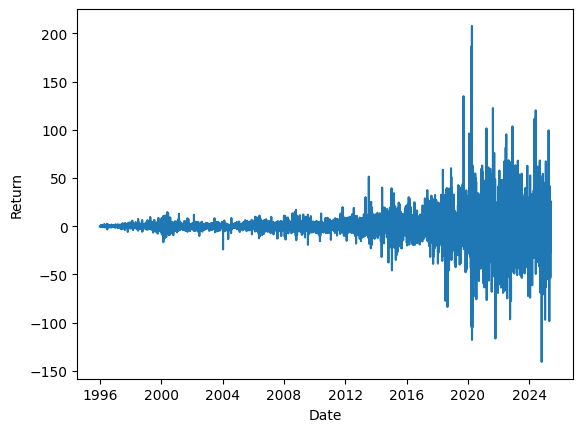

In [243]:
sns.lineplot(data = df3, x = "Date", y = "Return")

<Axes: xlabel='Date', ylabel='DailyReturn'>

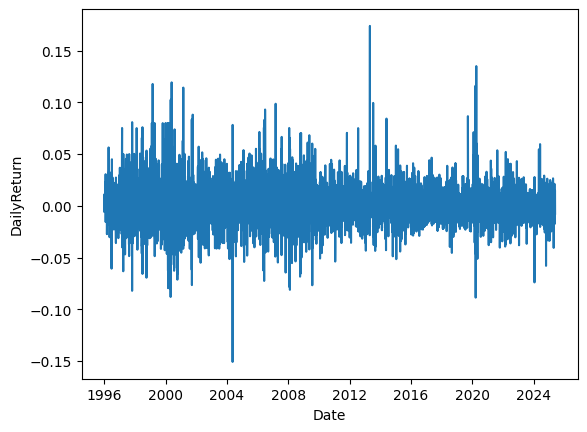

In [244]:
sns.lineplot(data=df3, x="Date", y="DailyReturn")

<Axes: xlabel='Date', ylabel='IntradayReturn'>

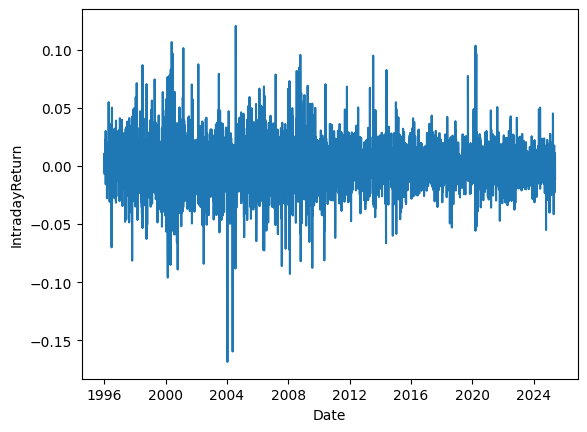

In [245]:
sns.lineplot(data=df3, x="Date", y="IntradayReturn")

<Axes: xlabel='Date', ylabel='Close'>

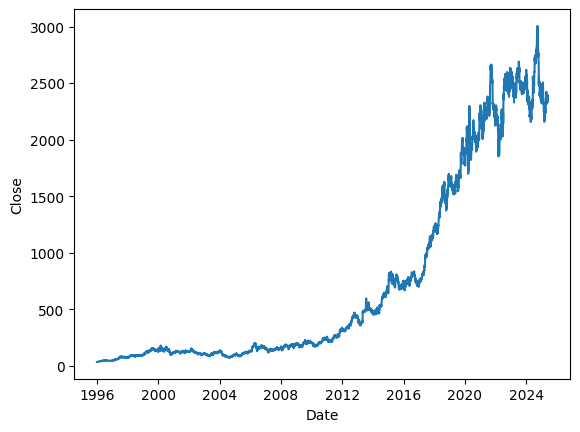

In [246]:
sns.lineplot(data=df3, x="Date", y="Close")

<Axes: xlabel='Date', ylabel='LogClose'>

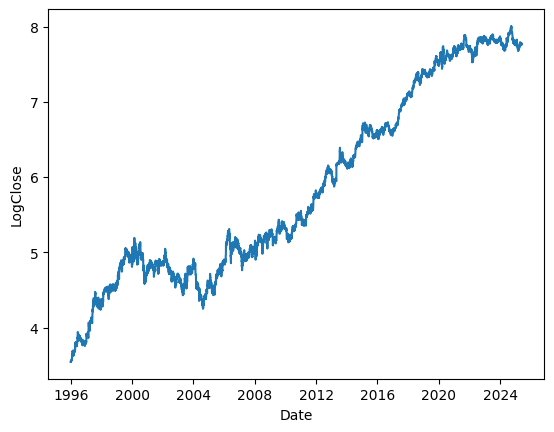

In [247]:
sns.lineplot(data=df3, x="Date", y="LogClose")

# ACF and PACF

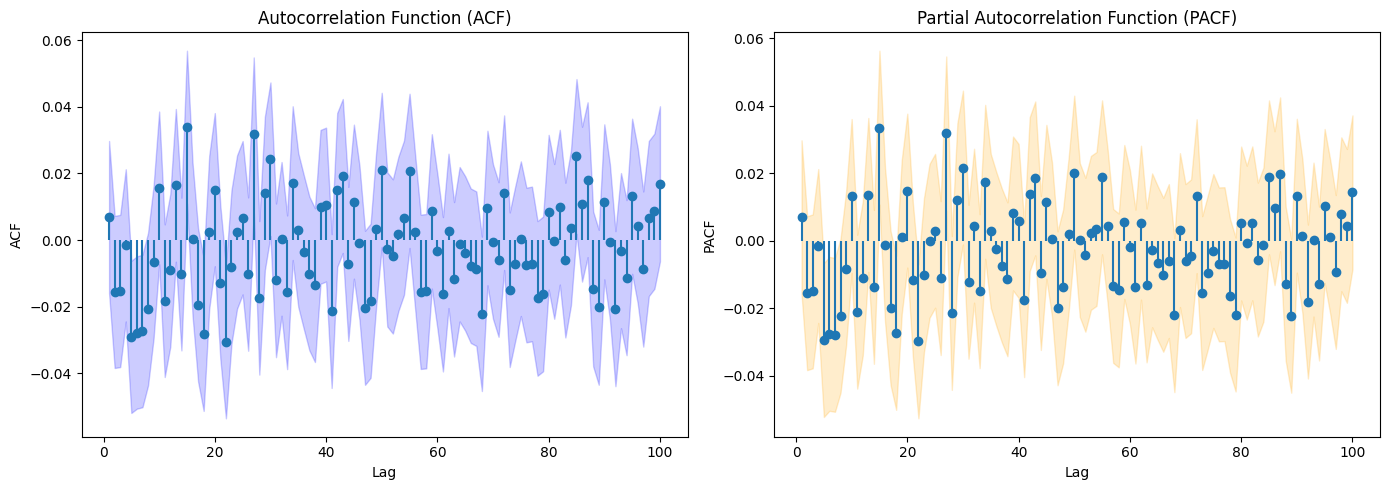

In [248]:
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
import numpy as np

# Series without NaNs
series = df3['DailyReturn'].dropna()

# Compute ACF and PACF with confidence intervals
acf_vals, acf_confint = acf(series, nlags=100, alpha=0.05)  # 95% CI
pacf_vals, pacf_confint = pacf(series, nlags=100, method='ywm', alpha=0.05)

# Exclude lag 0
lags = np.arange(1, 101)
acf_vals = acf_vals[1:]
acf_confint = acf_confint[1:]
pacf_vals = pacf_vals[1:]
pacf_confint = pacf_confint[1:]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
axes[0].stem(lags, acf_vals, basefmt=" ")
axes[0].fill_between(lags, acf_confint[:, 0] - acf_vals + acf_vals, acf_confint[:, 1] - acf_vals + acf_vals, 
                     color='blue', alpha=0.2)
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')

# PACF plot
axes[1].stem(lags, pacf_vals, basefmt=" ")
axes[1].fill_between(lags, pacf_confint[:, 0] - pacf_vals + pacf_vals, pacf_confint[:, 1] - pacf_vals + pacf_vals, 
                     color='orange', alpha=0.2)
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('PACF')

plt.tight_layout()
plt.show()


# Augmented Dickey Fuller

In [249]:
from statsmodels.tsa.stattools import adfuller

# Assuming df['Close'] contains your time series
result = adfuller(df['Close'].dropna())

# Print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Used lags:', result[2])
print('Number of observations:', result[3])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')


ADF Statistic: 0.42298147350218557
p-value: 0.9823343184504995
Used lags: 33
Number of observations: 7350
Critical Values:
   1%: -3.431240011602706
   5%: -2.861933316570829
   10%: -2.566979358119302


In [250]:
from statsmodels.tsa.stattools import adfuller

# Assuming df['Close'] contains your time series
result = adfuller(df['IntradayReturn'].dropna())

# Print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Used lags:', result[2])
print('Number of observations:', result[3])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -20.757933839421188
p-value: 0.0
Used lags: 14
Number of observations: 7369
Critical Values:
   1%: -3.4312377160244014
   5%: -2.861932302253562
   10%: -2.566978818183129


The p-value is 0.0 (much less than 0.05).
Thus series is stationary.

In [251]:
from statsmodels.tsa.stattools import adfuller

# Assuming df['Close'] contains your time series
result = adfuller(df['Return'].dropna())

# Print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Used lags:', result[2])
print('Number of observations:', result[3])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -14.581925017289008
p-value: 4.454265118798569e-27
Used lags: 36
Number of observations: 7347
Critical Values:
   1%: -3.4312403751481746
   5%: -2.861933477205856
   10%: -2.566979443627729


In [252]:
from statsmodels.tsa.stattools import adfuller

# Assuming df['Close'] contains your time series
result = adfuller(df['DailyReturn'].dropna())

# Print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Used lags:', result[2])
print('Number of observations:', result[3])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -16.234991404889925
p-value: 3.777866335578606e-29
Used lags: 29
Number of observations: 7353
Critical Values:
   1%: -3.4312396483539924
   5%: -2.8619331560669066
   10%: -2.566979272680667


# Load and Prepare Data

In [253]:
# df3['IntradayReturn'] = df3['IntradayReturn'] * 100
df3 = df3
print(df3.head())
series = df3['DailyReturn']
# series.index = pd.to_datetime(series.index)  # Ensure datetime index
# series.tail()


                       Date       Open      Close  IntradayReturn  LogClose  \
0 1995-12-31 18:30:00+00:00  34.845124  34.623840       -0.006371  3.544542   
1 1996-01-01 18:30:00+00:00  34.623829  34.993568        0.010622  3.555164   
2 1996-01-02 18:30:00+00:00  34.993582  34.786304       -0.005941  3.549224   
3 1996-01-03 18:30:00+00:00  34.733077  34.789097        0.001612  3.549304   
4 1996-01-04 18:30:00+00:00  34.789098  34.733078       -0.001612  3.547692   

     Return  DailyReturn  
0 -0.221284          NaN  
1  0.369739     0.010678  
2 -0.207277    -0.005923  
3  0.056020     0.000080  
4 -0.056020    -0.001610  


In [254]:
# series.describe()
print(series.head())

0         NaN
1    0.010678
2   -0.005923
3    0.000080
4   -0.001610
Name: DailyReturn, dtype: float64


In [255]:
series.index = pd.to_datetime(series.index)
print(series.head())

1970-01-01 00:00:00.000000000         NaN
1970-01-01 00:00:00.000000001    0.010678
1970-01-01 00:00:00.000000002   -0.005923
1970-01-01 00:00:00.000000003    0.000080
1970-01-01 00:00:00.000000004   -0.001610
Name: DailyReturn, dtype: float64


## Train-Test Split

In [256]:
split = int(len(series) * 0.8)
train, test = series[:split], series[split:]


## Fit ARMA Model

In [257]:
model = ARIMA(train, order=(2,0,2))  # We can tune order as needed here
fitted_model = model.fit()
print(fitted_model.summary())


                               SARIMAX Results                                
Dep. Variable:            DailyReturn   No. Observations:                 5907
Model:                 ARIMA(2, 0, 2)   Log Likelihood               15082.903
Date:                Tue, 17 Jun 2025   AIC                         -30153.806
Time:                        00:38:34   BIC                         -30113.703
Sample:                    01-01-1970   HQIC                        -30139.869
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      3.305      0.001       0.000       0.001
ar.L1          0.0082      1.586      0.005      0.996      -3.101       3.117
ar.L2         -0.0057      0.902     -0.006      0.9

## Forecast Intraday Returns

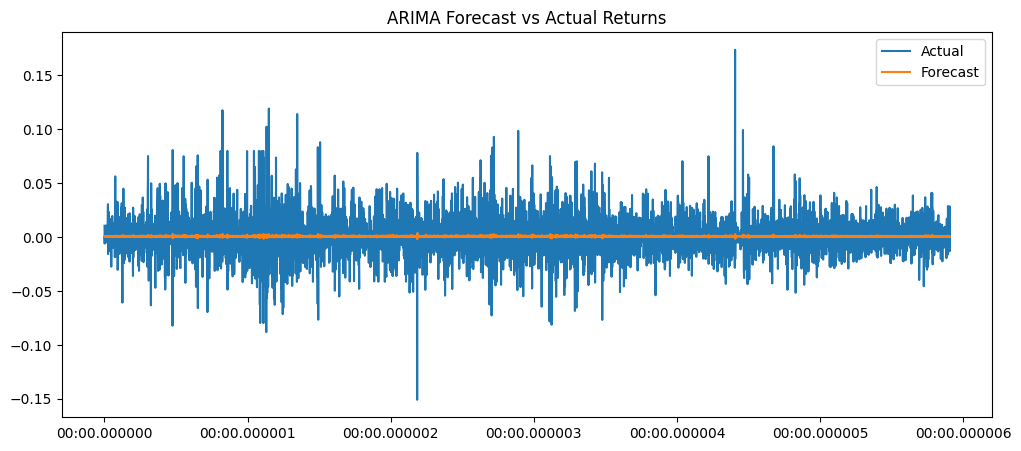

In [258]:
forecast = fitted_model.get_forecast(steps=len(train))
# mean_forecast = forecast.predicted_mean
predict = fitted_model.predict(start =train.index[0], end = train.index[-1])


plt.figure(figsize=(12,5))
plt.plot( train, label='Actual')
plt.plot( predict, label='Forecast')
plt.legend()
plt.title('ARIMA Forecast vs Actual Returns')
plt.show()


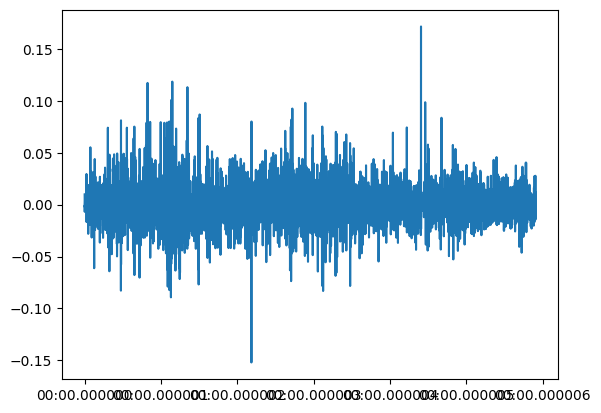

In [259]:
residuals = train - predict
plt.plot(residuals)
plt.show()

## Evaluate Forecast

In [260]:
# Combine and drop NaNs
eval_df = pd.DataFrame({'actual': train, 'predicted': predict}).dropna()

# Then calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

rmse = np.sqrt(mean_squared_error(eval_df['actual'], eval_df['predicted']))
mae = mean_absolute_error(eval_df['actual'], eval_df['predicted'])
directional_accuracy = (np.sign(eval_df['actual']) == np.sign(eval_df['predicted'])).mean()

print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"Directional Accuracy = {directional_accuracy:.2%}")


RMSE = 0.0188
MAE  = 0.0132
Directional Accuracy = 49.22%


Best ARIMA order: (0, 0, 7)


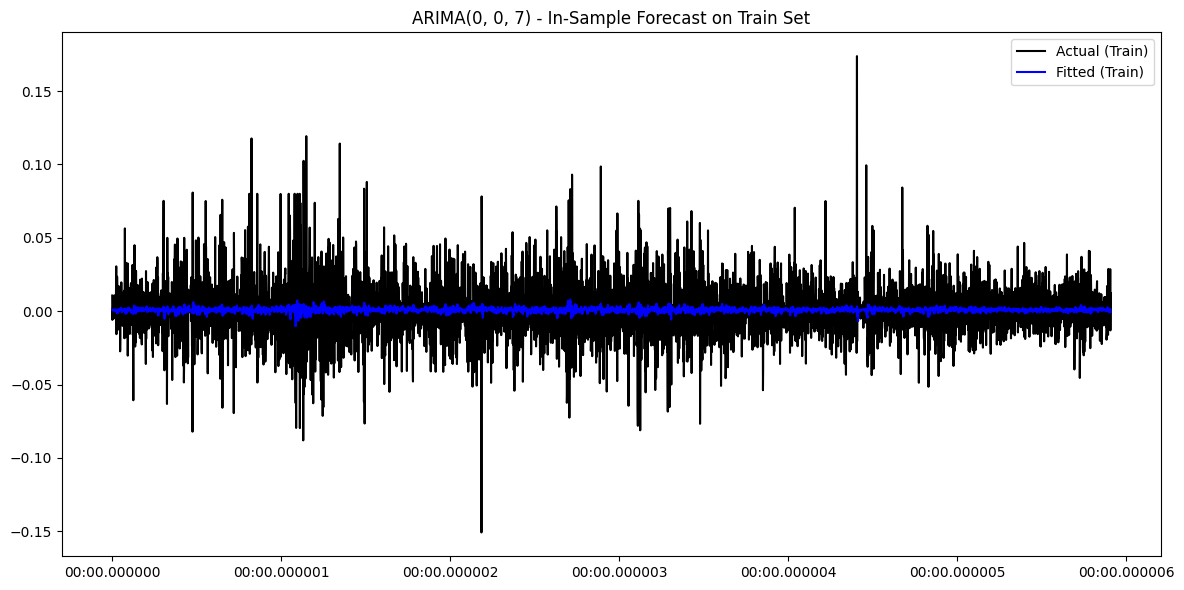

In [261]:
import pandas as pd
import numpy as np
import warnings
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

series = df3['DailyReturn']

# 1. Split into train/test
train_size = int(len(series) * 0.8)
train = series[:train_size]
# test = series[train_size:]  # not used here

# 2. Grid search for best (p,d,q) on train data
p = q = range(0, 8)
d = 0
pdq = [(i, d, j) for i in p for j in q]

best_aic = np.inf
best_order = None
best_model = None

for order in pdq:
    try:
        model = sm.tsa.ARIMA(train, order=order).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order = order
            best_model = model
    except:
        continue

print(f"Best ARIMA order: {best_order}")

# 3. In-sample forecast (fitted values)
fitted_values = best_model.fittedvalues

# Align with actual series
fitted_values = fitted_values.reindex_like(train)



# 4. Plot actual vs fitted on train
plt.figure(figsize=(12, 6))
plt.plot(train, label='Actual (Train)', color='black')
plt.plot(fitted_values, label='Fitted (Train)', color='blue')
plt.title(f"ARIMA{best_order} - In-Sample Forecast on Train Set")
plt.legend()
plt.tight_layout()
plt.show()

In [262]:
# Combine into a DataFrame to drop all rows with NaNs
df_eval = pd.DataFrame({'actual': train, 'predicted': fitted_values}).dropna()

# Now compute error metrics safely
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(df_eval['actual'], df_eval['predicted'])
rmse = np.sqrt(mean_squared_error(df_eval['actual'], df_eval['predicted']))
smape = 100 * np.mean(
    2 * np.abs(df_eval['actual'] - df_eval['predicted']) /
    (np.abs(df_eval['actual']) + np.abs(df_eval['predicted']))
)

print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"SMAPE = {smape:.2f}%")


MAE  = 0.0132
RMSE = 0.0188
SMAPE = 173.33%


# GARCH


🔍 Best GARCH order: p=1, q=3 (AIC=-31727.76)

📊 Error Metrics:
MAE  = 0.009935
MSE  = 0.000144
RMSE = 0.011981


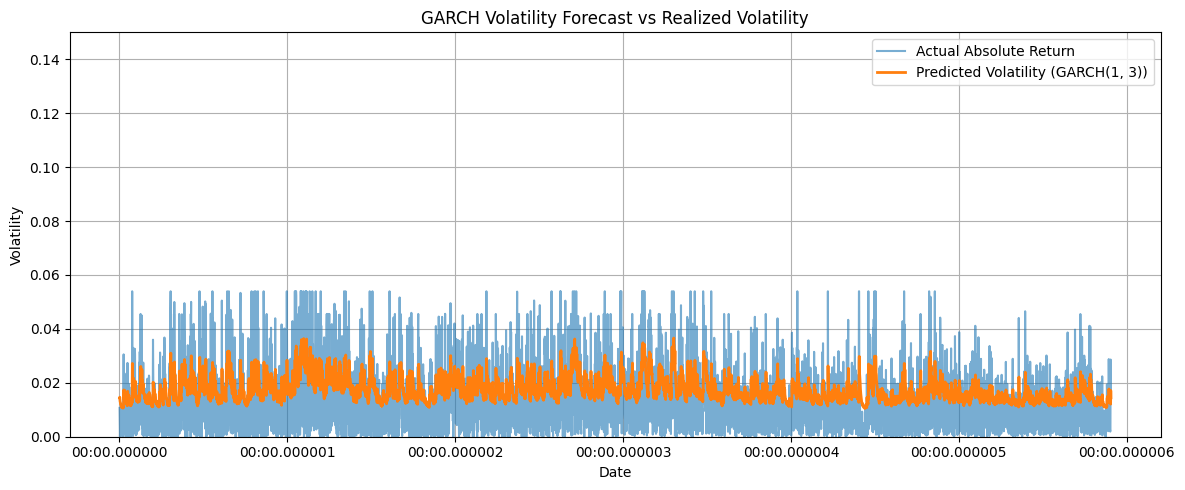

In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# If needed
# df3['Date'] = pd.to_datetime(df3['Date'])
# df3.set_index('Date', inplace=True)
returns = df3['DailyReturn'].dropna()

returns = returns.clip(lower=returns.quantile(0.01), upper=returns.quantile(0.99))

# Train-test split
split_ratio = 0.8
split_index = int(len(returns) * split_ratio)
train, test = returns[:split_index], returns[split_index:]




# Auto-tune GARCH order (on train set)
best_aic = np.inf
best_order = (1, 1)

for p in range(1, 4):
    for q in range(1, 4):
        try:
            model = arch_model(train, p=p, q=q)
            result = model.fit(disp='off')
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = (p, q)
        except:
            continue

print(f"\n🔍 Best GARCH order: p={best_order[0]}, q={best_order[1]} (AIC={best_aic:.2f})")

# Rolling forecast
predicted_vol = []
history = train.copy()

for t in range(len(train)):
    model = arch_model(history, p=best_order[0], q=best_order[1])
    model_fit = model.fit(disp='off')
    forecast = model_fit.forecast(horizon=1)
    vol = np.sqrt(forecast.variance.values[-1, 0])
    predicted_vol.append(vol)

    new_point = pd.Series(train.iloc[t], index=[train.index[t]])
    history = pd.concat([history, new_point])

predicted_vol_series = pd.Series(predicted_vol, index=train.index)

# Step 5: Error metrics
realized_vol = np.abs(train)

mae = mean_absolute_error(realized_vol, predicted_vol_series)
mse = mean_squared_error(realized_vol, predicted_vol_series)
rmse = np.sqrt(mse)

print(f"\n📊 Error Metrics:")
print(f"MAE  = {mae:.6f}")
print(f"MSE  = {mse:.6f}")
print(f"RMSE = {rmse:.6f}")




# Step 6: Plot results
plt.figure(figsize=(12, 5))
plt.plot(train.index, realized_vol, label='Actual Absolute Return', alpha=0.6)
plt.plot(train.index, predicted_vol_series, label=f'Predicted Volatility (GARCH{best_order})', linewidth=2)

plt.title('GARCH Volatility Forecast vs Realized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 0.15)
plt.show()


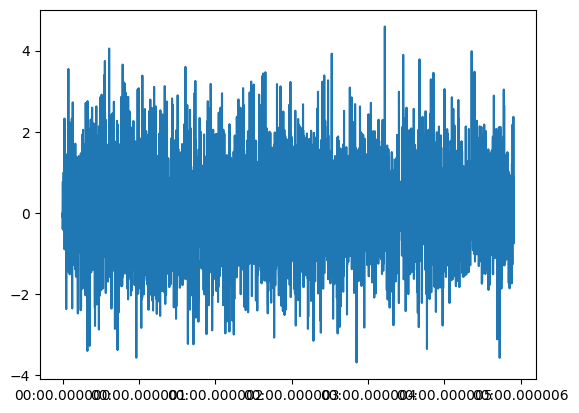

In [264]:
divSer = train/predicted_vol_series 
plt.plot(train.index, divSer, label=f'Predicted Volatility (GARCH{best_order})')
plt.show()

In [265]:
from statsmodels.tsa.stattools import adfuller

# Assuming df['Close'] contains your time series
result = adfuller(divSer.dropna())

# Print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Used lags:', result[2])
print('Number of observations:', result[3])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')


ADF Statistic: -75.29504296458231
p-value: 0.0
Used lags: 0
Number of observations: 5905
Critical Values:
   1%: -3.4314578992300993
   5%: -2.8620295881740514
   10%: -2.567030605537436


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4724
Model:                 ARIMA(8, 0, 2)   Log Likelihood               -6783.742
Date:                Tue, 17 Jun 2025   AIC                          13591.485
Time:                        00:48:48   BIC                          13669.010
Sample:                    01-01-1970   HQIC                         13618.734
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0399      0.015      2.737      0.006       0.011       0.069
ar.L1          0.6842      0.020     33.552      0.000       0.644       0.724
ar.L2         -0.9758      0.023    -42.233      0.0

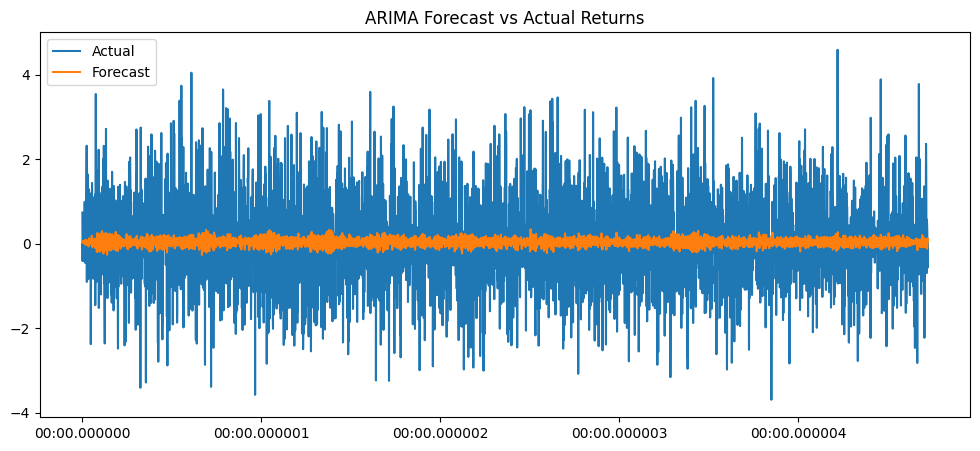

RMSE: 1.017215
MAE: 0.768994
Directional Accuracy: 50.49%


In [266]:
series = divSer
split = int(len(series) * 0.8)
train, test = series[:split], series[split:]

model = ARIMA(train, order=(8,0,2))  # We can tune order as needed here
fitted_model = model.fit()
print(fitted_model.summary())

forecast = fitted_model.get_forecast(steps=len(train))
# mean_forecast = forecast.predicted_mean
predict = fitted_model.predict(start =train.index[0], end = train.index[-1])


plt.figure(figsize=(12,5))
plt.plot( train, label='Actual')
plt.plot( predict, label='Forecast')
plt.legend()
plt.title('ARIMA Forecast vs Actual Returns')
plt.show()

rmse = root_mean_squared_error(train, predict)
mae = mean_absolute_error(train, predict)
directional_accuracy = (np.sign(train) == np.sign(predict)).mean()

print(f'RMSE: {rmse:.6f}')
print(f'MAE: {mae:.6f}')
print(f'Directional Accuracy: {directional_accuracy:.2%}')

In [267]:
# import pmdarima
# auto_arima = pmdarima.auto_arima(divSer, stepwise=False, seasonal=False)
# auto_arima
# auto_arima.summary()

Best ARIMA order: (7, 0, 5)


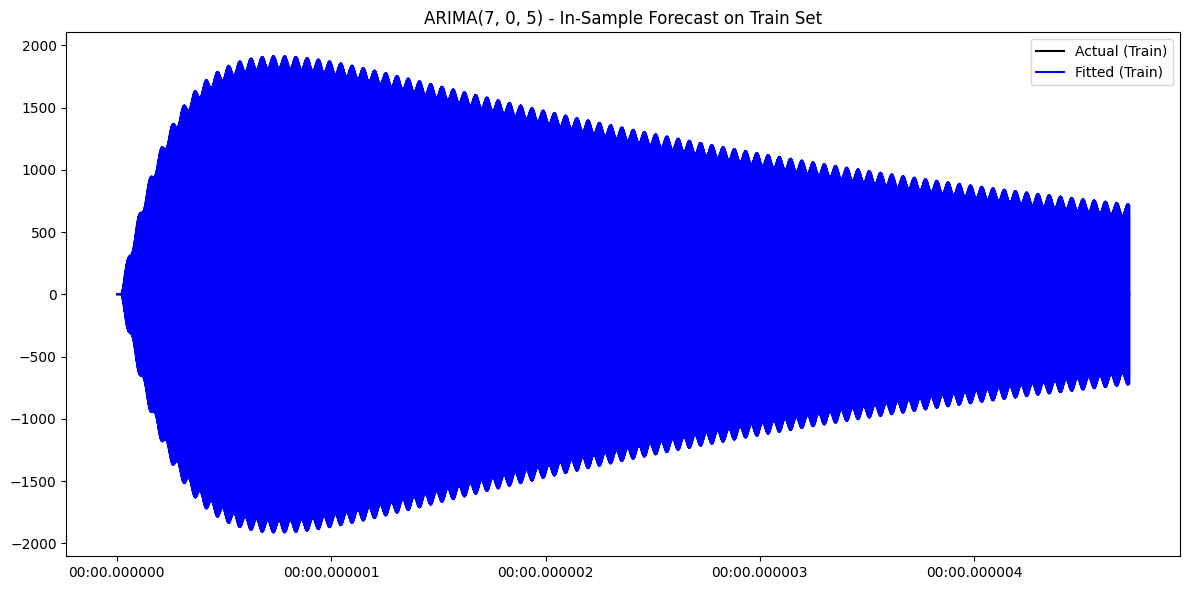

In [268]:
import pandas as pd
import numpy as np
import warnings
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

series = divSer

# 1. Split into train/test
train_size = int(len(series) * 0.8)
train = series[:train_size]
# test = series[train_size:]  # not used here

# 2. Grid search for best (p,d,q) on train data
p = q = range(0, 8)
d = 0
pdq = [(i, d, j) for i in p for j in q]

best_aic = np.inf
best_order = None
best_model = None

for order in pdq:
    try:
        model = sm.tsa.ARIMA(train, order=order).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order = order
            best_model = model
    except:
        continue

print(f"Best ARIMA order: {best_order}")

# 3. In-sample forecast (fitted values)
fitted_values = best_model.fittedvalues

# Align with actual series
fitted_values = fitted_values.reindex_like(train)



# 4. Plot actual vs fitted on train
plt.figure(figsize=(12, 6))
plt.plot(train, label='Actual (Train)', color='black')
plt.plot(fitted_values, label='Fitted (Train)', color='blue')
plt.title(f"ARIMA{best_order} - In-Sample Forecast on Train Set")
plt.legend()
plt.tight_layout()
plt.show()

In [269]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Error metrics
mae = mean_absolute_error(train, fitted_values)
rmse = np.sqrt(mean_squared_error(train, fitted_values))
# mape = mean_absolute_percentage_error(train, fitted_values) * 100

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

smape_val = smape(train, fitted_values)



print("\nError Metrics (Train Data):")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"SMAPE = {smape_val:.2f}%")


Error Metrics (Train Data):
MAE  = 1236.5599
RMSE = 1301.7777
SMAPE = 199.67%
